Converting the radical velocity to Cartesian velocity...

Our PPI is User1 - pulses/ray = 30000
Number of gates: 1600
Range gate length (m): 12.0
Gate length (pts): 4

Doppler radar background information: https://www.nssl.noaa.gov/publications/dopplerguide/chapter1.php

wavelength: 1550 nm



In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.linalg import pinv
from tqdm import tqdm
from math import atan, atan2

In [370]:
ds_raw = xr.open_dataset("/home/UOCNT/dli84/research/Bottle_lake/Field_data/Lidar_full_Burwood/netcdf/User1_252_20230502_002404_1_1-160.nc")

In [371]:
intensity = ds_raw["intensity"]

In [4]:
### input based on lidar config
prf = 30000 # pulse repetition frequency
nyquist = 19.4 ## based on paper
B = nyquist* 2
M = 4 # points per range gate
npulses = 30000


##   Standard deviation of velocity estimate (Rye and Hardesty, 1997)

In [5]:
# SNR = intensity -1
obs_signal = abs(intensity-1)
obs_signal.data[obs_signal.data<1e-5] = np.nan
### these are theoretical values
#signal to noise ratio
snr = 10**np.arange(-5,2.51, 0.01)
deltav = 1.5 #[1 1.5 2] typical signal spectral width - best value 1.5, or 2?
ff = deltav/B
Np = M*npulses*snr

In [6]:
# alpha = ratio of photon count to speckle count
# alpha_speckle = mySNR.*6;
alpha_speckle = snr/(np.sqrt(2*np.pi)*ff)
v_err_approx = np.sqrt(np.sqrt(8)* ff**2/(Np *alpha_speckle)*((1+1/(np.sqrt(2.*np.pi))*alpha_speckle)**2))*B
direct_detection = deltav/np.sqrt(Np)

v_err_pearson = 2*np.sqrt(np.sqrt(np.pi)/alpha_speckle)*(deltav/np.sqrt(Np))*(1+(1/(2*np.pi))*alpha_speckle)
# full treatment of gaussian pulse requires numerical integration
# The limits should be -0.5 to 0.5. Integrate from 0 to 0.5 and
# multiply by 2. This provides the Cramer-Rao lower bound (CRLB)
x  = np.arange(0,0.5001, 0.001)
a  = 10**np.arange(-4,4.1,0.1)  
g1 = np.zeros(len(a));
f  = np.zeros(len(a));
for ialpha in range(0,len(a)):
    g1[ialpha] = a[ialpha]/np.sqrt(2*np.pi)*2*np.sum((x**2*np.exp(-(x**2)))/(1+a[ialpha]*(np.exp(-(x**2)/2)**2)))*0.001
    f[ialpha] = 2*np.sum(((x/ff)**2)/((1 + 1/(a[ialpha]*(np.exp(-(x**2)/(2*ff**2)))))**2))*0.001
    
interp_func = interp1d(a,f)
new_f = interp_func(alpha_speckle)
v_err_crlb = np.sqrt(ff**2/npulses/M/new_f)*B

interp_func_v_err = interp1d(snr, v_err_crlb)
## now apply the error calculation to observations
v_error = np.zeros_like(obs_signal.data)
for itime in range(0, len(obs_signal.time)):
    v_error[itime,:] = interp_func_v_err(obs_signal[itime,:])

    
## This variable is
## the standard deviation of the velocity estimate, calculated
## from the SNR variable following Rye and Hardesty (1997). Note
## that this value is capped at the Nyquist velocity.
v_error_out = v_error.copy()
v_error_out[np.isnan(v_error_out)] = nyquist
v_error_out[v_error_out>nyquist] = nyquist

In [373]:
## save to netcdf
ds_raw["velocity_error"] = xr.DataArray(v_error_out, dims=["time","distance"], attrs={"units": "'ms-1'",  "long_name": "Std of velocity"})

In [374]:
## use a SNR mask to remove some data so we can save a bit computation time
ds_mask = ds_raw.where((1 > obs_signal) & (obs_signal > 0.01))

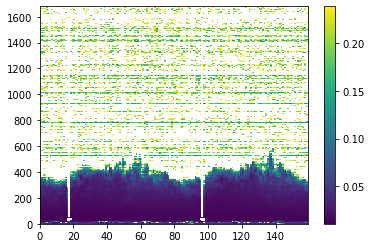

In [375]:
## have a look
plt.pcolormesh(ds_mask["velocity_error"].T)
plt.colorbar()

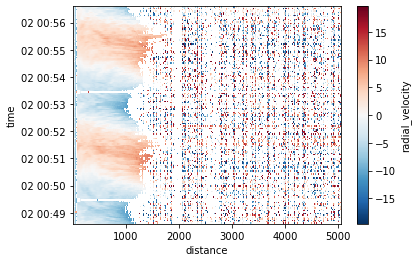

In [475]:
ds["radial_velocity"].plot()

## ppi2windsVAD

In [376]:
## functions to get sin and cos with input in degree
## just to save some typing time for me...
def sind(degree):
    return np.sin(np.deg2rad(degree))
def cosd(degree):
    return np.cos(np.deg2rad(degree))
## create nan array
def nan_arr(ref_data):
    arr_out = np.zeros_like(ref_data)
    arr_out[:] = np.nan
    return arr_out

In [377]:
ds = ds_mask

In [378]:
## initialise
u = nan_arr(ds["radial_velocity"].data)
v =  nan_arr(ds["radial_velocity"].data)
w =  nan_arr(ds["radial_velocity"].data)
ws =  nan_arr(ds["radial_velocity"].data)
wd =  nan_arr(ds["radial_velocity"].data)
u_error =  nan_arr(ds["radial_velocity"].data)
v_error =  nan_arr(ds["radial_velocity"].data)
w_error =  nan_arr(ds["radial_velocity"].data)
ws_error =  nan_arr(ds["radial_velocity"].data)
wd_error =  nan_arr(ds["radial_velocity"].data)
u_error_instr =  nan_arr(ds["radial_velocity"].data)
v_error_instr =  nan_arr(ds["radial_velocity"].data)
w_error_instr =  nan_arr(ds["radial_velocity"].data)
ws_error_instr =  nan_arr(ds["radial_velocity"].data)
wd_error_instr =  nan_arr(ds["radial_velocity"].data)
R_squared =  nan_arr(ds["radial_velocity"].data)
RMSE =  nan_arr(ds["radial_velocity"].data)
CN =  nan_arr(ds["radial_velocity"].data)


In [379]:
## we have two scans in each User1 file
## so need to split the azimuth
new_scan_id = np.argwhere(np.diff(ds["azimuth"].data)<0)[0][0]+1

In [380]:
# scan 1
A1 = np.array([sind(ds["azimuth"][:new_scan_id]) * sind(90-ds["elevation"][:new_scan_id]),
     cosd(ds["azimuth"][:new_scan_id]) * sind(90-ds["elevation"][:new_scan_id]),
     cosd(90-ds["elevation"][:new_scan_id])]).T
U1,S1,V1 =np.linalg.svd(A1, full_matrices=True)
D1 = np.zeros(A1.shape)
D1[:S1.shape[0],:S1.shape[0]] = np.diag(S1)
ds1 = ds.isel(time=slice(0,new_scan_id)).copy()

# scan 2
A2 = np.array([sind(ds["azimuth"][new_scan_id:]) * sind(90-ds["elevation"][new_scan_id:]),
     cosd(ds["azimuth"][new_scan_id:]) * sind(90-ds["elevation"][new_scan_id:]),
     cosd(90-ds["elevation"][new_scan_id:])]).T
U2,S2,V2 =np.linalg.svd(A2, full_matrices=True)
D2 = np.zeros(A2.shape)
D2[:S2.shape[0],:S2.shape[0]] = np.diag(S2)
ds2 = ds.isel(time=slice(new_scan_id,None)).copy()


In [463]:
%%time
## only perform fitting if there are enough data
for itime in tqdm(range(0,len(ds["time"])),position=0, leave=True):
    # scan 1
    if itime <= new_scan_id:
        A = A1
        U = U1
        D = D1
        V = V1
        ds_scan = ds1
    # scan 2
    else:
        A = A2
        U = U2
        D = D2
        V = V2
        ds_scan = ds2
    for igate in range(0,len(ds_scan["distance"])):
        vr = ds_scan["radial_velocity"][:,igate].data
        az = ds_scan["azimuth"].data
        el = ds_scan["elevation"].data
        if len(ds_scan["radial_velocity"][:,igate]) - np.isnan(ds_scan["radial_velocity"][:,igate]).sum() < 6:
            u[itime, igate] = np.nan
            v[itime, igate] = np.nan
            w[itime, igate] = np.nan
            ws[itime, igate] = np.nan
            wd[itime, igate] = np.nan
            u_error_instr[itime, igate] = np.nan
            v_error_instr[itime, igate] = np.nan
            w_error_instr[itime, igate] = np.nan
            ws_error_instr[itime, igate] = np.nan
            wd_error_instr[itime, igate] = np.nan
            R_squared[itime, igate] = np.nan
            RMSE[itime, igate] = np.nan
            CN[itime, igate] = np.nan
            u_error[itime, igate] = np.nan
            v_error[itime, igate] = np.nan
            w_error[itime, igate] = np.nan
            ws_error[itime, igate] = np.nan
            wd_error[itime, igate] = np.nan
        # Wind components

        # Require finite data only - an issue for Leosphere systems with thresholding applied 
        else:
            ## if there's NaN in the data
            ## redo the SVD
            if len(np.argwhere(np.isnan(ds_scan["radial_velocity"][:,igate].data)))>0:
                index_mask = ~np.isnan(ds_scan["radial_velocity"][:,igate].data)
                az = ds_scan["azimuth"].data[index_mask]
                el = ds_scan["elevation"].data[index_mask]
                vr = ds_scan["radial_velocity"][:,igate].data[index_mask]
                nA = np.array([sind(az)*sind(90-el), 
                               cosd(az)*sind(90-el), 
                               cosd(90-el)]).T
                nU,nS,nV = np.linalg.svd(nA, full_matrices=True)
                nD = np.zeros(nA.shape)
                nD[:nS.shape[0],:nS.shape[0]] = np.diag(nS)
                ## use diag to change nD to full 2D matrix
                wind_components = np.dot(np.dot(np.dot(nV, pinv(nD)), nU[:,:].T), vr )
                A = nA
                
            else:
                wind_components = np.dot(np.dot(np.dot(V, pinv(D)), U[:,:].T),vr)
                ## bring back the A without NaNs
                if itime <= new_scan_id:
                    A = A1
                # scan 2
                else:
                    A = A2
            u[itime, igate] = wind_components[0]
            v[itime, igate] = wind_components[1]
            w[itime, igate] = wind_components[2]
            ## wind speed
            ws[itime, igate] = np.sqrt(u[itime, igate]**2+v[itime, igate]**2)

            ## wind direction
            r2d = 45.0/atan(1.0)# conversion factor
            wd[itime, igate] = atan2(u[itime, igate], v[itime, igate]) * r2d + 180

            ##--- Error propagation ---##        
#             # variance-covariance matrices
#             C_vr_vr = np.diag(vr)
#             C_v_v = np.dot(np.dot(pinv(A), C_vr_vr), np.transpose(pinv(A)))
            
#             ## Instrumental random noise error for u,v,w
#             wind_comp_error = np.sqrt(np.diag(C_v_v))
#             u_error_instr[itime, igate] = wind_comp_error[0]
#             v_error_instr[itime, igate] = wind_comp_error[1]
#             w_error_instr[itime, igate] = wind_comp_error[2]

#             ## Instrumental random noise error for wind speed and direction
#             ws_error_instr[itime, igate] = np.sqrt((u[itime, igate]*u_error_instr[itime, igate])**2 + (v[itime, igate]*v_error_instr[itime, igate])**2) / np.sqrt(u[itime, igate]**2+v[itime, igate]**2)
#             wd_error_instr[itime, igate] = np.sqrt((u[itime, igate]*v_error_instr[itime, igate])**2 + (v[itime, igate]*u_error_instr[itime, igate])**2) / (np.sqrt(u[itime, igate]**2+v[itime, igate]**2))**2

#             ## Calculate sine wave fit and goodness-of-fit values
#             _, R_squared[itime, igate], RMSE[itime, igate] = calcualte_Sinusodial_Fit(az, vr)

#             ## calculate condition number CN
#             s_1 = (np.dot(A[:,0].T, A[:,0]))**(-1/2)
#             s_2 = (np.dot(A[:,1].T, A[:,1]))**(-1/2)
#             s_3 = (np.dot(A[:,2].T, A[:,2]))**(-1/2)
#             S = np.diag([s_1,s_2,s_3])
#             Z = np.dot(A , S)
#             CN[itime,igate] = np.max(np.linalg.svd(Z)[1]) / np.min(np.linalg.svd(Z)[1])
#             # As discussed by Newsom et al. (2017), radial velocity error is
#             # comprised of instrumental noise and turbulent contribution since
#             # a radial velocity measurement is averaged over n number of beams.
#             # Here it is assumed that the total radial velocity uncertainty is
#             # unknown, and more specifically the turbulent contribution of the
#             # uncertainty is unknown. Thus, the overall uncertainty sigma_r, as
#             # discussed by Newsom et al. (2017), is set to 1.
#             sigma_r = 1
#             tmp_C_all = np.zeros((3,3))
#             tmp_PSI_all = 0
#             for k in range(0, len(az)):
#                 r_k = np.array([[sind(az[k])*cosd(az[k])], \
#                [cosd((az[k]))*cosd(az[k])], \
#                [sind(az[k])]])
#                 tmp_C = ((np.transpose(r_k)*r_k))/(sigma_r**2)
#                 tmp_C_all = tmp_C_all + tmp_C
#                 tmp_PSI = ((np.dot(np.transpose(wind_components), r_k) - ds_scan["radial_velocity"][k,igate].data)**2) / (sigma_r**2)
#                 tmp_PSI_all = tmp_PSI_all + tmp_PSI
                
#             C_newsom = np.linalg.inv(tmp_C_all)
#             PSI = np.sqrt(tmp_PSI_all)
#             u_error[itime,igate] = PSI * np.sqrt(C_newsom[0,0] / (len(az) - 3))
#             v_error[itime,igate] = PSI * np.sqrt(C_newsom[1,1] / (len(az) - 3))
#             w_error[itime,igate] = PSI * np.sqrt(C_newsom[2,2] / (len(az) - 3))
            
#             ### Note: if the total uncertainty of radial velocity would be
#             ### known the wind component errors could be calculated by:
#             ### Sigma_uvw = sqrt(diag(C_newsom));
#             ### u_error(i) = Sigma_uvw(1);
#             ### v_error(i) = Sigma_uvw(2);
#             ### w_error(i) = Sigma_uvw(3);

#             # Wind speed and direction error as given by Newsom et al. (2017)
#             ws_error[itime,igate] = np.sqrt((u[itime,igate]*u_error[itime,igate])**2 + (v[itime,igate]*v_error[itime,igate])**2) / np.sqrt(u[itime,igate]**2+v[itime,igate]**2)
#             wd_error[itime,igate] = np.sqrt((u[itime,igate]*v_error[itime,igate])**2 + (v[itime,igate]*u_error[itime,igate])**2) / (np.sqrt(u[itime,igate]**2+v[itime,igate]**2))**2

100%|██████████| 159/159 [05:25<00:00,  2.05s/it]

CPU times: user 5min 25s, sys: 299 ms, total: 5min 25s
Wall time: 5min 25s


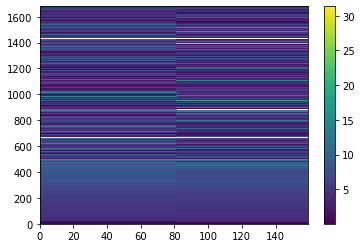

In [473]:
plt.pcolor(ws.T)
plt.colorbar()

## calculate sinusodial fit...


In [22]:
from scipy.optimize import curve_fit

In [303]:
def sinfunc(x, b1, b2, b3, b4):  
    return b1 * np.sin(2*np.pi*x/b2 + 2*np.pi/b3) + b4
def funfcn(params,x,y):
    b1, b2, b3, b4 = params
    fcn = np.nansum((sinfunc(x, b1, b2, b3, b4)-y)**2)
    return fcn

#### function minimizer

In [152]:
def funcMinimizer(x0=[yr,  per,  -1,  ym], x = x, y = y):
    '''
    funcMinimizer tried to find a local minimizer 'x0' of function 'funfcn.'
    'funfcn' is a function handle, and accepts input 'x0' and returns scalar 
    function value 'fval' evaluated at 'x', which can be scalar, vector or matrix.
    '''

    ## parameters
    max_func = 800
    max_iterations = 800
    tolerance_func = 1.0000e-4
    tolerance_x = 1.0000e-4
    varargin = []
    no_of_x = len(x0)
    # Initialize parameters
    rho = 1
    chi = 2
    psi = 0.5
    sigma = 0.5
    ## fubar parameters
    ## this one is to select the first elements in MATLAB
    fubar_ones_n_of_x = np.ones(no_of_x)
    # this one is to select the elements except the first one in MATLAB
    # plus one more as the matrix is gonna be 4 by 5
    # so selecting along different coordinates
    fubar_two_2_n_p_1 = np.arange(1,no_of_x+1,1)

    # this one is to select the elements except the last one 
    fubar_one_2_n = np.arange(0,no_of_x,1)

    # Set first guesses
    fubar_x_in = x0 
    fubar_vee = np.zeros((no_of_x,no_of_x+1)) 
    fubar_fv =  np.zeros(no_of_x+1)
    fubar_vee[:,0] = fubar_x_in # put first guesses in
    # x = fubar_x_in.copy()    # Change x for funfcn
    fubar_fv[0] = funfcn(fubar_x_in,x ,y)
    itercount = 0
    usual_delta = 0.05 # 5 percent 
    zero_term_delta = 0.00025 # 0.025 percent for zero elements of x

    fubar_y = fubar_x_in
    for j in range(0,no_of_x):
        if fubar_y[j] != 0:
            fubar_y[j] = (1 + usual_delta)*fubar_y[j]
        else:
            fubar_y[j] = zero_term_delta

        fubar_vee[:,j+1] = fubar_y
        fubar_f = funfcn(fubar_y,x,y)
        fubar_fv[j+1] = fubar_f
    # sort so vee[0,:] has the lowest function value
    j_sort = np.argsort(fubar_fv)
    fubar_vee = fubar_vee[:,j_sort]
    
    ## parameters again
    how = 'initial simplex'
    itercount = itercount + 1
    func_evals = no_of_x+1
    while func_evals < max_func and itercount<max_iterations:
        # from MATLAB code:
        # np.abs(fubar.fv[0]-fubar.fv(fubar.two_2_n_p_1))
        param_1 = np.nanmax([np.abs(fubar_fv[0]-fubar_fv[i]) for i in fubar_two_2_n_p_1])
        # max(Params.tolerance_func,10*eps(fubar.fv(1)))
        param_2 = np.nanmax((tolerance_func, 10*np.spacing(fubar_fv[0])))
        # max(max(abs(fubar.vee(:,fubar.two_2_n_p_1)-fubar.vee(:,fubar.ones_n_of_x))))
        param_3 = np.nanmax([np.abs(fubar_vee[:,i])-fubar_vee[:,0] for i in fubar_two_2_n_p_1])
        # max(Params.tolerance_x,10*eps(max(fubar.vee(:,1))))
        param_4 = np.nanmax((tolerance_x,10*np.spacing(np.nanmax(fubar_vee[:,0]))))
        if param_1 <= param_2 and param_3 <= param_4:
            break
        # Compute the reflection point
        # fubar.xbar = average of the n (NOT n+1) best points
        fubar_xbar = np.sum(fubar_vee[:,:no_of_x], axis=1)/no_of_x
        fubar_xr = (1 + rho)*fubar_xbar - rho*fubar_vee[:,-1]
        fubar_fxr = funfcn(fubar_xr,x,y)
        func_evals = func_evals+1

        if fubar_fxr < fubar_fv[0]:
            #Calculate the expansion point
            fubar_xe = (1 + rho*chi)*fubar_xbar - rho*chi * fubar_vee[:,-1] 
            fubar_fxe = funfcn(fubar_xe,x,y)
            func_evals = func_evals+1
            if fubar_fxe < fubar_fxr:
                fubar_vee[:,-1]  = fubar_xe
                fubar_fv[-1] = fubar_fxe
                how = 'expand'
            else:
                fubar_vee[:,-1] = fubar_xr
                fubar_fv[-1] = fubar_fxr
                how = 'reflect'
        else: # fubar.fxr >= fv(:,1)
            if fubar_fxr < fubar_fv[no_of_x]:
                fubar_vee[:,-1] = fubar_xr
                fubar_fv[-1] = fubar_fxr
                how = 'reflect'
            else: # fubar.fxr >= fv(:,n)
                 # Perform contraction
                if fubar_fxr < fubar_fv[-1]:
                # Perform an outside contraction
                    fubar_xc = (1 + psi * rho) * fubar_xbar - psi * rho * fubar_vee[:,-1]
                    fubar_fxc = funfcn(fubar_xc,x,y)
                    func_evals = func_evals + 1

                    if fubar_fxc <= fubar_fxr:
                        fubar_vee[:,-1] = fubar_xc
                        fubar_fv[-1] = fubar_fxc
                        how = 'contract outside'
                    else:
                        ## flag to perform shrink
                        how = 'shrink'
                else:
                    # Perform an inside contraction
                    fubar_xcc = (1-psi) * fubar_xbar + psi * fubar_vee[:,-1]
                    fubar_fxcc = funfcn(fubar_xcc,x,y)
                    func_evals = func_evals + 1

                    if fubar_fxcc < fubar_fv[-1]:
                        fubar_vee[:,-1] = fubar_xcc
                        fubar_fv[-1] = fubar_fxcc
                        how = 'contract inside'
                    else:
                        # flag to perform a shrink
                        how = 'shrink'
            # check if need to perform shrink
            if 'shrink' in how:
                for j in fubar_two_2_n_p_1:
                    fubar_vee[:,j] = fubar_vee[:,0] + sigma * (fubar_vee[:,j] - fubar_vee[:,0])
                    fubar_fv[j] = funfcn(fubar_vee[:,j],x,y)
                ## add counts
                func_evals = func_evals + no_of_x

        j_sort = np.argsort(fubar_fv)
        fubar_vee = fubar_vee[:,j_sort]
        itercount = itercount + 1     
    ## output 
    params = fubar_vee[:,0]
    fval = fubar_fv[0]
    return(params, fval)

In [444]:
def calcualte_Sinusodial_Fit(az, vr):
    # vr = ds1["radial_velocity"][:,igate]
    iazi = np.argsort(az)
    x = az[iazi]*np.pi/180
    y = vr[iazi] - vr.min().data

    yu = np.nanmax(y)
    yl = np.nanmin(y)
    ## range of y
    yr = yu-yl
    yz = y-yu+(yr/2)
    ### Find zero-crossings
    ### zx = x(yz .* circshift(yz,[-1 1]) <= 0);
    # Estimate period
    ### per = 2*nanmean(diff(zx));
    per = 2 * np.pi
    # Estimate offset
    ym = np.nanmean(y)
    popt, pcov = curve_fit(sinfunc, x, y)
    b1,b2,b3,b4 = popt
    # Minimise Least-Squares
    s = funcMinimizer([yr,  per,  -1,  ym], x, y)
    xp = np.linspace(np.nanmin(x),np.nanmax(x),len(x))
    # calc fit and shift back
    b1,b2,b3,b4 = s[0]
    sine_fit = sinfunc(xp, b1,b2,b3,b4)+vr.mean().data

    isort = np.argsort(iazi)
    sine_fit = sine_fit[isort] #  order back w.r.t time

    ## Goodness-of-fit parameters
    R_squared = 1 - np.nansum((vr[iazi] - (np.transpose(sinfunc(xp, b1,b2,b3,b4)) + np.nanmean(vr[iazi]))  )**2) / np.nansum((vr[iazi] - np.nansum(vr[iazi]))**2)
    RMSE = np.sqrt(np.nansum(sine_fit - vr)**2 / len(vr))
    return( sine_fit, R_squared, RMSE)